# DRAMMIMO
Delayed Rejection Adaptive Metropolis Multi Input Multi Output

By: Wei Gao (wg14@my.fsu.edu)

## Initialization.
Import necessary modules.

In [ ]:
import numpy as np
import scipy.linalg as la
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import matplotlib.lines as mline
import os

## Define the function for getting estimation chains.
Estimation chains of model parameters are generated based on the modified DRAM algorithm.

In [ ]:
def getDRAMMIMOChains(data,model,modelParams,DRAMParams):
    ## Initialize parameters.

    # Number of data sets.
    numDataSets = np.array([len(data['xdata']),len(data['ydata']), \
                            len(model['fun']),len(model['errFun']),len(model['ssFun']), \
                            len(modelParams['extra'])])
    if np.any(numDataSets-numDataSets[0]):
        raise ValueError('Unequal numbers of sets in either data or model.')
    N = numDataSets[0]
    # Number of data within each set.
    numDataPoints = np.tile(0,(N,2))
    for i in np.arange(0,N):
        numDataPoints[i,:] = np.array([data['xdata'][i].shape[0],data['ydata'][i].shape[0]])
    if np.any(numDataPoints-numDataPoints[0,0]):
        raise ValueError('Unequal numbers of data points.')
    n = numDataPoints[0,0]
    # Number of model parameters for estimation.
    p = len(modelParams['values'])
    # Number of estimation iterations already done.
    Mo = DRAMParams['numDRAMIterationsDone']
    if Mo!=1 and Mo!=DRAMParams['previousResults']['chain_q'].shape[0]:
        raise ValueError('The number of given previous results does not match the number of iterations already done.')
    # Number of estimation iterations to be done in total.
    M = DRAMParams['numDRAMIterations']

    # Best model parameter estimation.
    if Mo==1:
        q = np.array([modelParams['values']]).T
    else:
        q = np.array([DRAMParams['previousResults']['chain_q'][-1,:]]).T
    # Old model parameter estimation.
    q0 = np.zeros(q.shape)
    # 1st stage new model parameter estimation.
    q1 = np.zeros(q.shape)
    # 2nd stage new model parameter estimation.
    q2 = np.zeros(q.shape)

    # Model prediction errors caused by q.
    err = np.zeros((n,N))
    # Calculate errors.
    for i in np.arange(N):
        err[:,i] = model['errFun'][i](q,data['xdata'][i],data['ydata'][i],modelParams['extra'][i]).T
    # Model prediction errors caused by q0.
    err0 = np.zeros((n,N))
    # Model prediction errors caused by q1.
    err1 = np.zeros((n,N))
    # Model prediction errors caused by q2.
    err2 = np.zeros((n,N))

    # Initialize the covariance matrix of parameter estimations and its inverse.
    if Mo==1:
        cov_q = np.diag(((q!=0)*(0.05*q)**2+(q==0)*1.0)[:,0])
    else:
        cov_q = DRAMParams['previousResults']['last_cov_q']
    if p==1:
        cov_q_inv = 1.0/cov_q
    else:
        cov_q_inv = la.inv(cov_q)

    # Initialize the covariance matrix of parameter estimation errors and its inverse.
    if Mo==1:
        cov_err = np.diag((np.tile(1E-4,(1,N)))[0,:])
    else:
        cov_err = DRAMParams['previousResults']['chain_cov_err'][-1,:,:]
    if N==1:
        cov_err_inv = 1.0/cov_err
    else:
        cov_err_inv = la.inv(cov_err)

    # Parameters for inverse-wishart distribution.
    psi_s = np.diag((np.tile(1E-4,(1,N)))[0,:])
    nu_s = 1

    # Parameters for Adaptive Metropolis.
    # Adaptive interval.
    ko = 100
    # Adaptive scale.
    sp = 2.38/np.sqrt(p)
    # Up-to-date mean parameter estimations.
    if Mo==1:
        qBar = q.copy()
    else:
        qBar = np.array([np.mean(DRAMParams['previousResults']['chain_q'],0)]).T
    # Up-to-data covariance matrix of parameter estimations.
    qCov = cov_q.copy()

    # Parameters for Delayed Rejection.
    # Maximum random walk step size.
    randomWalk = la.cholesky(cov_q)
    # 1st stage random walk maximum step size.
    R1 = randomWalk/1.0
    # 2nd stage random walk maximum step size.
    R2 = randomWalk/5.0

    ## Initialize the chain.

    # The chain of model parameter estimations for posterior densities.
    chain_q = np.zeros((M,p))
    if Mo==1:
        chain_q[0,:] = q.T.copy()
    else:
        chain_q[:Mo,:] = DRAMParams['previousResults']['chain_q']

    # The chain of model parameter estimation covariances is not of interest for now.
    # Record the latest value instead.
    last_cov_q = cov_q.copy()

    # The chain of model prediction errors is not of interest for now.
    
    # The chain of model prediction error covariances for uncertainty propagation.
    chain_cov_err = np.zeros((M,N,N))
    if Mo==1:
        chain_cov_err[0,:,:] = cov_err
    else:
        chain_cov_err[:Mo,:,:] = DRAMParams['previousResults']['chain_cov_err']

    # Generate the chain.
    for k in np.arange(Mo,M,1):
        # Display current model parameter estimations every xth iteration.
        # Modify the number in mod() after k as needed.
        # Comment this out if not necessary, i.e. to avoid time delay.
        if np.mod(k,200)==0:
            print(np.vstack((k,q)).T)
        # Save current estimation chain every yth iteration.
        # Modify the number in mod() after k+1 as needed.
        # Comment this out if not necessary, i.e. to avoid time delay.
        if np.mod(k,1000)==0:
            np.savez_compressed(os.getcwd()+'/chains'+str(k), \
                                chain_q=chain_q, \
                                last_cov_q=last_cov_q, \
                                chain_cov_err=chain_cov_err)

        ######## Start of Delayed Rejection ########

        # Record the best guess from last step as the old guess.
        q0 = q.copy()
        err0 = err.copy()

        # 1st stage Random Walk.
        q1 = q0+np.array([np.dot(R1.T,np.random.randn(len(q)))]).T # Laine
        
        if any(q1.T[0,:]<modelParams['lowerLimits']) or any(q1.T[0,:]>modelParams['upperLimits']):
            # If the new guess is out of the bounds ...
            err1 = np.tile(float('inf'),(n,N))
            SS0 = np.trace(np.dot(np.dot(err0.T,err0),cov_err_inv))
            SS1 = float('inf')
            pi10 = 0.0
            alpha10 = min(1,pi10)
        else:
            # If the new guess is within the bounds ...
            for i in np.arange(N):
                err1[:,i] = model['errFun'][i](q1,data['xdata'][i],data['ydata'][i],modelParams['extra'][i]).T

            if np.any(np.isnan(err1)):
                # If the new guess is causing the model response to be NaN ...
                err1 = np.tile(float('inf'),(n,N))
                SS0 = np.trace(np.dot(np.dot(err0.T,err0),cov_err_inv))
                SS1 = float('inf')
                pi10 = 0;
                alpha10 = min(1,pi10)
            else:
                # If the new guess is okay ...
                SS0 = np.trace(np.dot(np.dot(err0.T,err0),cov_err_inv))
                SS1 = np.trace(np.dot(np.dot(err1.T,err1),cov_err_inv))
                # pi(q1|q0)
                pi10 = np.exp(-0.5*(SS1-SS0))
                # alpha(q1|q0)
                alpha10 = min(1,pi10)

        # Decide whether to accept the 1st stage new guess.
        if alpha10>np.random.rand():
            # Accept the 1st stage new guess.

            # Record the 1st stage new guess as the best guess.
            q = q1.copy()
            err = err1.copy()

        else:
            # Reject the 1st stage new guess.

            # 2nd stage Random Walk.
            # q2 = q0+np.array([np.dot(R2,np.random.randn(len(q)))]).T # Smith
            q2 = q0+np.array([np.dot(R2.T,np.random.randn(len(q)))]).T # Laine

            if any(q2.T[0,:]<modelParams['lowerLimits']) or any(q2.T[0,:]>modelParams['upperLimits']):
                # If the new guess is out of the bounds ...
                err2 = np.tile(float('inf'),(n,N))
                SS2 = float('inf')
                pi20 = 0.0
                pi12 = 0.0
                alpha20 = 0.0
                alpha210 = 0.0
            else:
                # If the new guess is within the bounds ...
                for i in np.arange(N):
                    err2[:,i] = model['errFun'][i](q2,data['xdata'][i],data['ydata'][i],modelParams['extra'][i]).T

                if np.any(np.isnan(err2)):
                    # If the new guess is causing the model response to be NaN ...
                    err2 = np.tile(float('inf'),(n,N))
                    SS2 = float('inf')
                    pi20 = 0.0
                    pi12 = 0.0
                    alpha12 = 0.0
                    alpha210 = 0.0
                else:
                    # If the new guess is okay ...
                    SS2 = np.trace(np.dot(np.dot(err2.T,err2),cov_err_inv))
                    # pi(q1|v)/pi(q0|v)
                    pi20 = np.exp(-0.5*(SS2-SS0))
                    # J(q1|q2)
                    J12 = np.exp(-0.5*np.dot(np.dot((q1-q2).T,cov_q_inv),(q1-q2)))[0][0]
                    # J(q1|q0)
                    J10 = np.exp(-0.5*np.dot(np.dot((q1-q0).T,cov_q_inv),(q1-q0)))[0][0]
                    # pi(q1|v)/pi(q0|v)
                    pi12 = np.exp(-0.5*(SS1-SS2))
                    # alpha(q1|q2)
                    alpha12 = min(1,pi12)
                    # alpha(q2|q0,q1)       
                    if alpha12==1:
                        alpha210 = 0
                    else:
                        alpha210 = min(1,pi20*J12/J10*(1-alpha12)/(1-alpha10))

            # Decide whether to accept the 2nd stage new guess.
            if alpha210>np.random.rand():
                # Accept the 2nd stage new guess.

                # Record the 2nd stage new guess as the best guess.
                q = q2.copy()
                err = err2.copy()

        ######## End of Delayed Rejection ########

        ######## Start of Adaptive Metropolis ########

        # Record the chain.
        chain_q[k,:] = q.T.copy()
        last_cov_q = cov_q.copy()
        chain_cov_err[k,:,:] = cov_err.copy()

        # Update cov_err and cov_err_inv.
        cov_err = st.invwishart.rvs(nu_s+n,psi_s+np.dot(err.T,err),size=1,random_state=None)
        if N==1:
            cov_err_inv = 1.0/cov_err
        else:
            cov_err_inv = la.inv(cov_err)

        # Update cov_q and cov_q_inv.
        # No update in the 1st round (1 round = ko steps).
        if k==ko-1:
            # Calculate at the end of the 1st round (ko-th step).
            # Mean parameter estimations.
            qBar = np.array([np.mean(chain_q[0:ko,:],0)]).T
            # Covariance of parameter estimations.
            qCov = np.cov(chain_q[0:ko,:].T)
        elif k>=ko:
            # Keep calculating after the ko-th step.
            # Mean parameter estimations.
            qBarOld = qBar.copy()
            qBar = (k*qBarOld+q)/(k+1)
            # Covariance of parameter estimations.
            qCovOld = qCov.copy()
            qCov = (k-1.0)/k*qCovOld+1.0/k*(k*np.dot(qBarOld,qBarOld.T)-(k+1)*np.dot(qBar,qBar.T)+np.dot(q,q.T))

            # Update at the end of every round since the ko-th step.
            if np.mod(k+Mo,ko)==0:
                cov_q = qCov.copy();
                if p==1:
                    cov_q_inv = 1.0/cov_q
                else:
                    cov_q_inv = la.inv(cov_q)
                randomWalk = la.cholesky(cov_q)
                R1 = randomWalk*sp
                R2 = randomWalk*sp/5.0

        ######## End of Adaptive Metropolis ########

    return chain_q,last_cov_q,chain_cov_err

## Define the function for getting posterior densities.
Posterior densities of model parameters are obtained based on the estimation chains using guassian kernel.

In [ ]:
def getDRAMMIMODensities(qChain):
    numIterations = qChain.shape[0]
    numChains = qChain.shape[1]
    numNodes = 100
    qMin = np.amin(qChain,0)
    qMax = np.amax(qChain,0)
    qRange = qMax-qMin
    qVals = np.zeros([numNodes,numChains])
    qProbs = np.zeros(qVals.shape)

    for i in np.arange(numChains):
        qVals[:,i] = np.linspace(qMin[i]-0.08*qRange[i],qMax[i]+0.08*qRange[i],numNodes)

        chainSorted = np.sort(qChain[:,i])
        i1 = int(np.floor((numIterations+1)/4.0))
        i3 = int(np.floor((numIterations+1)/4.0*3.0))
        f1 = (numIterations+1)/4.0-i1;
        f3 = (numIterations+1)/4.0*3.0-i3
        q1 = (1-f1)*chainSorted[i1-1]+f1*chainSorted[i1]
        q3 = (1-f3)*chainSorted[i3-1]+f3*chainSorted[i3]
        iRange = q3-q1

        if iRange<=0:
            s = 1.06*np.std(qChain[:,i])*np.power(numIterations,-1.0/5.0)
        else:
            s = 1.06*np.min([np.std(qChain[:,i]),iRange/1.34])*np.power(numIterations,-1.0/5.0)

        for j in np.arange(numNodes):
            err = (qVals[j,i]-qChain[:,i])/s
            qProbs[j,i] = 1.0/numIterations*np.sum(np.exp(-0.5*np.power(err,2))/np.sqrt(2*np.pi))/s

    return qVals,qProbs

## Define the function for getting credible and prediction intervals.
Credible and prediction intervals are generated by propagating uncertainty of model parameters through the models.

In [ ]:
def getDRAMMIMOIntervals(data,model,modelParams,chain_q,chain_cov_err,nSample):
    # Initialize parameters. Using 95% intervals.
    xData = data['xdata']
    lims = [0.025, 0.5, 0.975]
    m = chain_q.shape[0]
    N = len(xData)
    n = xData[0].shape[0]

    # Get the indices of points to be pulled out of the estimation chain.
    if nSample == m:
        iSample = np.arange(0,m,1).astype(int)
    else:
        iSample = np.floor(np.random.rand(nSample)*m).astype(int)

    # Sample the estimation chain for the credible region as ysave and the prediction region as osave.
    ySave = np.zeros((N,nSample,n))
    oSave = np.zeros((N,nSample,n))
    for iiSample in np.arange(nSample):
        qi = np.array([chain_q[iSample[iiSample],:]]).T
        randError = np.array([np.random.multivariate_normal(np.zeros(N),chain_cov_err[iSample[iiSample],:,:])]).T
        for i in np.arange(N):
            y = model['fun'][i](qi,xData[i],modelParams['extra'][i])
            ySave[i,iiSample,:] = y.T
            oSave[i,iiSample,:] = y.T+randError[i,0]

    # Interpolate the credible and prediction intervals.
    credLims = np.zeros((N,len(lims),n))
    predLims = np.zeros((N,len(lims),n))
    for i in np.arange(N):
        ySaveSorted = np.sort(ySave[i,:,:],axis=0)
        oSaveSorted = np.sort(oSave[i,:,:],axis=0)
        for j in np.arange(n):
            credLims[i,:,j] = np.interp(np.array(lims)*(nSample-1),np.arange(nSample),ySaveSorted[:,j])
            predLims[i,:,j] = np.interp(np.array(lims)*(nSample-1),np.arange(nSample),oSaveSorted[:,j])

    return credLims,predLims

## Define the model functions.
The model functions yield model predictions that can be compared to the data.

In [ ]:
def getModelResponse(theta,xdata,extra):
    # 'extra' can be used to pass extra parameter values.
    # These parameters are needed by the model, but not being estimated.
    if extra[0]==0:
        a = theta[0,0]
        b = theta[1,0]
    else:
        a = theta[0,0]
        b = theta[1,0]

    modelResponse = a*xdata+b

    return modelResponse

## Define the model error functions.
The model error functions yield the discrepancies between the model predictions and the data.

In [ ]:
def getModelResponseError(theta,xdata,ydata,extra):
    # 'extra' can be used to pass extra parameter values.
    # These parameters are needed by the model, but not being estimated.
    modelResponse = getModelResponse(theta,xdata,extra)
    modelResponseError = modelResponse-ydata

    return modelResponseError

## Main function.
This is the main function if the module is executed by itself instead of being imported to other modules.

In [ ]:
if __name__ == '__main__':
    ## Below is an example of how to use DRAMMIMO.

    # Load the data.
    print('Loading data...')
    # Fictitious data are generated here for a linear model y = a*x + b.
    # Two data sets are available.
    inputData1 = np.array([np.linspace(0,1,101)]).T
    inputData2 = np.array([np.linspace(0,1,101)]).T
    outputData1 = 0.8*inputData1+0.05*np.array([np.random.randn(101)]).T
    outputData2 = 1.2*inputData2+0.15*np.array([np.random.randn(101)]).T

    # Set up DRAMMIMO.
    print('Setting DRAMMIMO...')
    # Scenarios with one ro two data sets are differentiated by mode.
    # mode = 1: using one data set (Bayesian method).
    # mode = 2: using two data sets (Maximum Entropy method).
    mode = 2
    if mode==1:
        data = {'xdata':[inputData1], \
                'ydata':[outputData1]}
        model = {'fun':[getModelResponse], \
                 'errFun':[getModelResponseError], \
                 'ssFun':[getModelResponseSS]}
        modelParams = {'names':['a','b'],\
                       'values':[1,0], \
                       'lowerLimits':[-float('inf'),-float('inf')], \
                       'upperLimits':[float('inf'),float('inf')], \
                       'extra':[[0,]]}
    elif mode==2:
        data = {'xdata':[inputData1,inputData2], \
                'ydata':[outputData1,outputData2]}
        model = {'fun':[getModelResponse,getModelResponse], \
                 'errFun':[getModelResponseError,getModelResponseError], \
                 'ssFun':[getModelResponseSS,getModelResponseSS]}
        modelParams = {'names':['a','b'],\
                       'values':[1,0], \
                       'lowerLimits':[-float('inf'),-float('inf')], \
                       'upperLimits':[float('inf'),float('inf')], \
                       'extra':[[0,],[0,]]}

    # Get estimation chains.
    # The estimation chains can be obtained ini multiple consecutive runs.
    # 1st round.
    numDone = 1
    numTotal = 5000
    DRAMParams = {'numDRAMIterationsDone':numDone, \
                  'numDRAMIterations':numTotal, \
                  'previousResults': {'chain_q':[], \
                                      'last_cov_q':[], \
                                      'chain_cov_err':[]}}
    print('Running DRAMMIMO...')
    chain_q,last_cov_q,chain_cov_err = getDRAMMIMOChains(data,model,modelParams,DRAMParams)
    print('Finished.')
    # 2nd round.
    numDone = numTotal
    numTotal = 10000
    DRAMParams = {'numDRAMIterationsDone':numDone, \
                  'numDRAMIterations':numTotal, \
                  'previousResults': {'chain_q':chain_q, \
                                      'last_cov_q':last_cov_q, \
                                      'chain_cov_err':chain_cov_err}}
    print('Running DRAMMIMO...')
    chain_q,last_cov_q,chain_cov_err = getDRAMMIMOChains(data,model,modelParams,DRAMParams)
    print('Finished.')

    np.savez_compressed(os.getcwd()+'/chains'+str(numTotal), \
                        chain_q=chain_q, \
                        last_cov_q=last_cov_q, \
                        chain_cov_err=chain_cov_err)

    # Get posterior densities.
    num = round(chain_q.shape[0]/2.0)
    vals,probs = getDRAMMIMODensities(chain_q[num:,:])
    
    np.savez_compressed(os.getcwd()+'/densities'+str(numTotal), \
                        vals=vals, \
                        probs=probs)

    # Get credible and prediction intervals.
    nSample = 500
    credLims,predLims = getDRAMMIMOIntervals(data,model,modelParams,chain_q,chain_cov_err,nSample)
    
    np.savez_compressed(os.getcwd()+'/intervals'+str(numTotal), \
                        credLims=credLims, \
                        predLims=predLims)

    ## Plot the results.    
    print('Plotting results...')

    figNum = 0

    # Data.
    figNum += 1
    plt.figure(figNum,figsize=(10,6))
    plt.plot(inputData1,outputData1,'bo',markerfacecolor='None',label='Data I')
    plt.plot(inputData2,outputData2,'ro',markerfacecolor='None',label='Data II')
    plt.xlabel('$x$',fontsize=18)
    plt.ylabel('$y$',fontsize=18)
    plt.xlim(0,1)
    plt.ylim(-0.1,1.3)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(loc='upper left',fontsize=18,frameon=False)

    # Estimation chains.
    figNum += 1
    plt.figure(figNum,figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(np.arange(1,chain_q.shape[0]+1,1),chain_q[:,0],'.')
    plt.xticks([])
    plt.yticks(fontsize=18)
    plt.ylabel('$a$',fontsize=18)
    plt.xlim(0,chain_q.shape[0])
    plt.ylim(np.min(chain_q[:,0]),np.max(chain_q[:,0]))
    plt.subplot(2,1,2)
    plt.plot(np.arange(1,chain_q.shape[0]+1,1),chain_q[:,1],'.')
    plt.xticks([])
    plt.yticks(fontsize=18)
    plt.xlabel('Iterations',fontsize=18)
    plt.ylabel('$b$',fontsize=18)
    plt.xlim(0,chain_q.shape[0])
    plt.ylim(np.min(chain_q[:,1]),np.max(chain_q[:,1]))

    # Posterior densities.
    figNum += 1
    plt.figure(figNum,figsize=(10,6))
    plt.subplot(1,2,1)
    plt.plot(vals[:,0],probs[:,0],'k',linewidth=3)
    plt.xlabel('$a$',fontsize=18)
    plt.xlim(np.min(vals[:,0]),np.max(vals[:,0]))
    # plt.xticks(fontsize=18)
    plt.yticks([])
    plt.ylabel('Posterior Density',fontsize=18)
    plt.subplot(1,2,2)
    plt.plot(vals[:,1],probs[:,1],'k',linewidth=3)
    plt.xlabel('$b$',fontsize=18)
    plt.xlim(np.min(vals[:,1]),np.max(vals[:,1]))
    # plt.xticks(fontsize=18)
    plt.yticks([])

    # Credible and prediction intervals for data set I.
    figNum += 1
    fig, ax = plt.subplots(figsize=(10,6))
    limitX = np.vstack((inputData1,np.flip(inputData1,axis=0)))
    predLimitY = np.vstack((np.array([predLims[0,0,:]]).T,np.array(np.fliplr([predLims[0,2,:]])).T))
    predLimits = mpatch.Polygon(np.hstack((limitX,predLimitY)),facecolor=(1,0.75,0.5))
    ax.add_patch(predLimits)
    credLimitY = np.vstack((np.array([credLims[0,0,:]]).T,np.array(np.fliplr([credLims[0,2,:]])).T))
    credLimits = mpatch.Polygon(np.hstack((limitX,credLimitY)),facecolor=(0.75,1,0.5))
    ax.add_patch(credLimits)
    plt.plot(inputData1,credLims[0,1,:],'k')
    plt.plot(inputData1,outputData1,'bo',markerfacecolor='None')
    plt.xlabel('$x$',fontsize=18)
    plt.ylabel('$y_1$',fontsize=18)
    plt.xlim(0,1)
    plt.ylim(-0.7,2)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    lgd = [mpatch.Patch(facecolor=(1,0.75,0.5),edgecolor='None',label='95% Pred Interval'), \
           mpatch.Patch(facecolor=(0.75,1,0.5),edgecolor='None',label='95% Cred Interval'), \
           mline.Line2D([0],[0],color='k',label='Model'), \
           mline.Line2D([0],[0],marker='o',color='None',markerfacecolor='None',markeredgecolor='b',label='Data I')]
    plt.legend(handles=lgd,loc='upper left',fontsize=18,frameon=False)

    # Credible and prediction intervals for data set II.
    if mode==2:
        figNum += 1
        fig, ax = plt.subplots(figsize=(10,6))
        limitX = np.vstack((inputData2,np.flip(inputData2,axis=0)))
        predLimitY = np.vstack((np.array([predLims[1,0,:]]).T,np.array(np.fliplr([predLims[1,2,:]])).T))
        predLimits = mpatch.Polygon(np.hstack((limitX,predLimitY)),facecolor=(1,0.75,0.5))
        ax.add_patch(predLimits)
        credLimitY = np.vstack((np.array([credLims[1,0,:]]).T,np.array(np.fliplr([credLims[1,2,:]])).T))
        credLimits = mpatch.Polygon(np.hstack((limitX,credLimitY)),facecolor=(0.75,1,0.5))
        ax.add_patch(credLimits)
        plt.plot(inputData2,credLims[1,1,:],'k')
        plt.plot(inputData2,outputData2,'ro',markerfacecolor='None')
        plt.xlabel('$x$',fontsize=18)
        plt.ylabel('$y_2$',fontsize=18)
        plt.xlim(0,1)
        plt.ylim(-0.7,2)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        lgd = [mpatch.Patch(facecolor=(1,0.75,0.5),edgecolor='None',label='95% Pred Interval'), \
               mpatch.Patch(facecolor=(0.75,1,0.5),edgecolor='None',label='95% Cred Interval'), \
               mline.Line2D([0],[0],color='k',label='Model'), \
               mline.Line2D([0],[0],marker='o',color='None',markerfacecolor='None',markeredgecolor='r',label='Data II')]
        plt.legend(handles=lgd,loc='upper left',fontsize=18,frameon=False)

    # Show plots.
    plt.show()

## Results.
An example of a simple linear model is presented here to demonstrate how to use the package. The uncertainty quantification results of the example are presented below.

### Fictitious data.
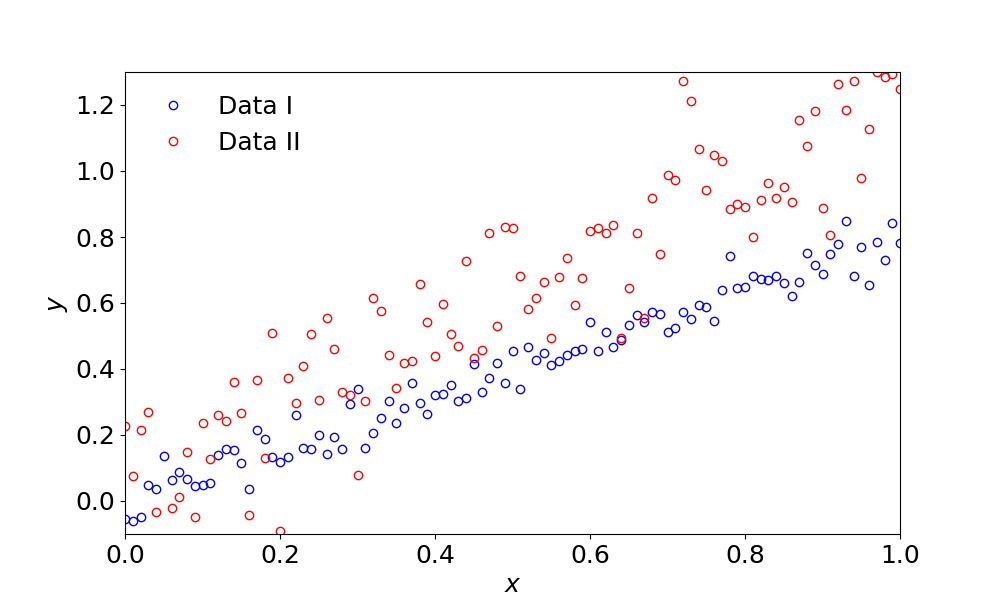

### Estimation chains.
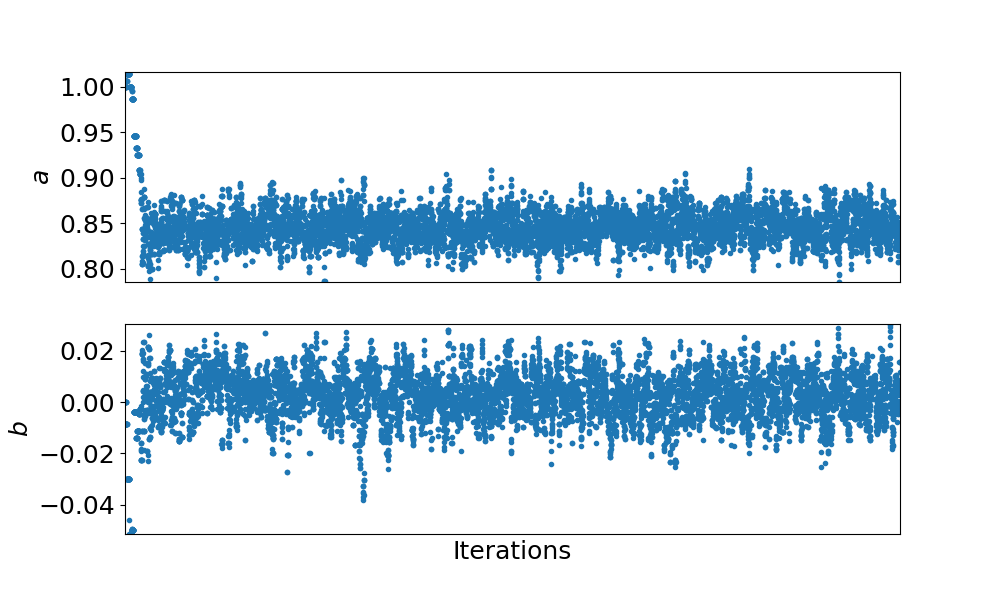

### Posterior densities.
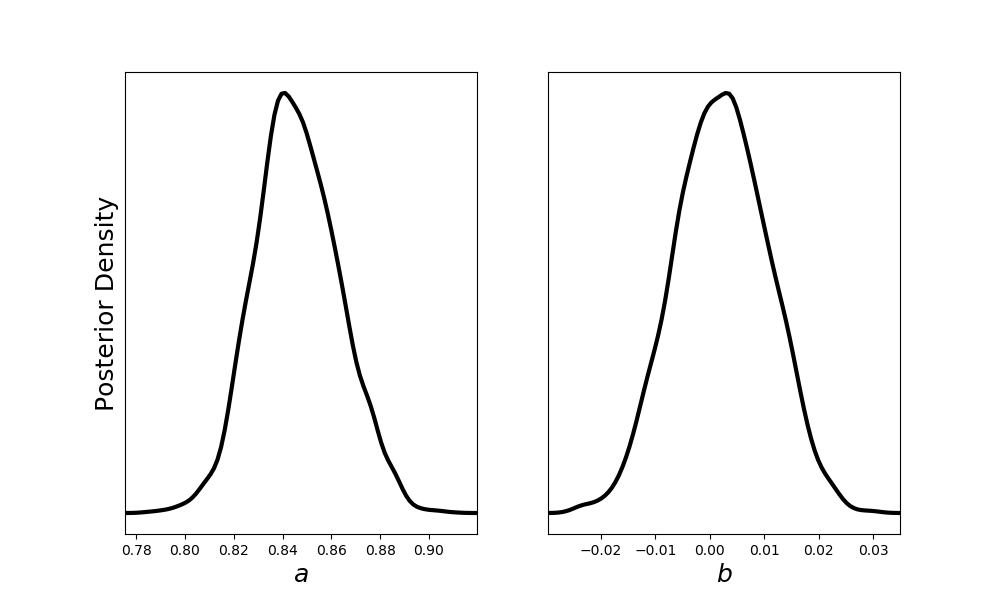

### Credible and prediction intervals.
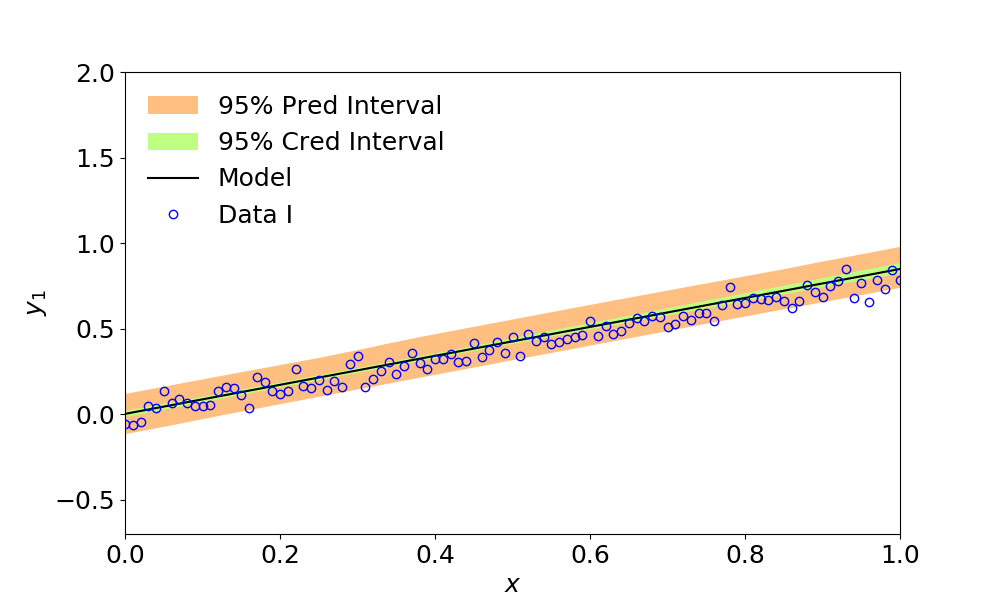
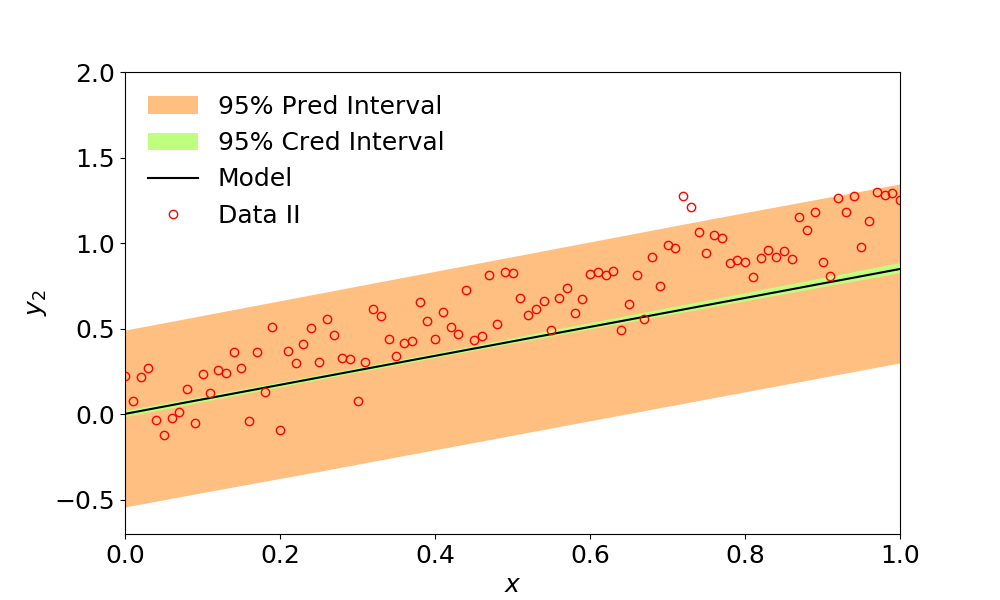